#💾 **Importando JSON.**

##📌 Bibliotecas.

In [627]:
import pandas as pd
import requests
from pandas import json_normalize
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors
import plotly.graph_objects as go

In [628]:
#pip install mplcursors

In [629]:
url = "https://raw.githubusercontent.com/EuniceGarcia503/Challenge2_TelecomX_LATAM/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."



*   customerID: número de identificación único de cada cliente
*   Churn: si el cliente dejó o no la empresa
*   gender: género (masculino y femenino)
*   SeniorCitizen: información sobre si un cliente tiene 65 años o más
*   Partner: si el cliente tiene pareja o no
*   Dependents: si el cliente tiene dependientes o no
*   tenure: meses de contrato del cliente
*   PhoneService: suscripción de servicio telefónico
*   MultipleLines: suscripción a más de una línea de teléfono
*   InternetService: suscripción a un proveedor de internet
*   OnlineSecurity: suscripción adicional de seguridad online
*   OnlineBackup: suscripción adicional de backup online
*   DeviceProtection: suscripción adicional de protección en el dispositivo
*   TechSupport: suscripción adicional de soporte técnico, menos tiempo de espera
*   StreamingTV: suscripción de TV por cable
*   StreamingMovies: suscripción de streaming de películas
*   Contract: tipo de contrato
*   PaperlessBilling: si el cliente prefiere recibir la factura online
*   PaymentMethod: forma de pago
*   Charges.Monthly: total de todos los servicios del cliente por mes
*   Charges.Total: total gastado por el cliente

#🧰 **Transformación.**

##🛠️ **Normalización de Columnas.**

In [630]:
df_telecomX_normalizado = pd.json_normalize(data)
df_telecomX_normalizado.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


##🛠️ **Identificación de Inconsistencias en Datos.**

In [631]:
# Código para Verificación de Valores Únicos por Columna.
print(f"📝Resumen para Verificación de Valores Únicos por Columna.\n")
for col in df_telecomX_normalizado.columns:
  print(f"🟣 Columna: '{col}': {df_telecomX_normalizado[col].nunique()}\n")

  if df_telecomX_normalizado[col].nunique() < 50: # Imprima los valores solamente si no hay muchos
    print(f"\t✏️ valores = {df_telecomX_normalizado[col].unique()}\n")
  print('-' * 50)  # Línea divisoria para mejor visualización

📝Resumen para Verificación de Valores Únicos por Columna.

🟣 Columna: 'customerID': 7267

--------------------------------------------------
🟣 Columna: 'Churn': 3

	✏️ valores = ['No' 'Yes' '']

--------------------------------------------------
🟣 Columna: 'customer.gender': 2

	✏️ valores = ['Female' 'Male']

--------------------------------------------------
🟣 Columna: 'customer.SeniorCitizen': 2

	✏️ valores = [0 1]

--------------------------------------------------
🟣 Columna: 'customer.Partner': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'customer.Dependents': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'customer.tenure': 73

--------------------------------------------------
🟣 Columna: 'phone.PhoneService': 2

	✏️ valores = ['Yes' 'No']

--------------------------------------------------
🟣 Columna: 'phone.MultipleLines': 3

	✏️ valores = ['No' 'Yes' 'No phone service']

------------

In [632]:
# Verificando si hay duplicados
print(f"📝 Resumen de Verificación de Datos duplicados y Núlos.\n")
duplicados = df_telecomX_normalizado.duplicated().sum()
print(f"🟣 Número de líneas duplicadas:\n")

if  duplicados:
    print(f"\t🔸{duplicados}")
else:
    print("   ✅ No hay registros duplicados.")


# Verificando si hay valores Nulos
valores_nulos = df_telecomX_normalizado.isnull().sum()
valores_nulos.name = 'Valores Nulos'
valores_nulos_filtrados = valores_nulos[valores_nulos > 0]

print(f"\n🟣 Valores nulos por columna:\n")
if not valores_nulos_filtrados.empty:
    for columna, cantidad in valores_nulos_filtrados.items():
        print(f"\t🔸 {columna}: {cantidad}")
else:
    print("   ✅ No hay columnas con datos nulos.\n")
    display(valores_nulos)


📝 Resumen de Verificación de Datos duplicados y Núlos.

🟣 Número de líneas duplicadas:

   ✅ No hay registros duplicados.

🟣 Valores nulos por columna:

   ✅ No hay columnas con datos nulos.



,Valores Nulos
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [633]:
#código para calcular valores sin registro
valores_blanco_vacio = df_telecomX_normalizado.apply(lambda x: x.astype(str).str.strip() == '').sum()
valores_blanco_vacio.name = 'Registro en blanco'
print("\n📝 Resumen para Registros en Blanco por Columna.\n")
display(valores_blanco_vacio)


📝 Resumen para Registros en Blanco por Columna.



,Registro en blanco
customerID,0
Churn,224
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [634]:
df_telecomX_normalizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [635]:
#1. Columna 'SeniorCitizen'(0,1)(objet)Se puede convertir sus valores a 'Yes' o 'No'
#2. Columnas 'Contract y 'PaymentMethod' podríamos unir palabras por un guion (-) para tokenizar
#3. Columna 'PaymentMethod' remover (), reemplazar espacios por guion.
#4. Columna 'Charges.Total' convertir a tipo float64.
#5. Columnas 'Churn' ''
#6. Tratamiento preventivo para columnas tipo texto: Remover espacios al inicio y final,convertimos a minúscula, removemos valores nulos por desconocido.
#7. Tratamiento preventivo para columnas con caracteres numericos y conversión tipo float64.

##🛠️ **Manejo de Inconsistencias en Datos.**

In [636]:
#Tratamiento mínimo para columnas tipo cadena de texto.
#Remover espacios al inicio y final,convertimos a minúscula, removemos valores nulos por desconocido.
df_telecomX_normalizado = df_telecomX_normalizado.apply(lambda x: x.astype(str).str.lower())

In [637]:
#Retornamos formato de id_cliente.
df_telecomX_normalizado['customerID'] = df_telecomX_normalizado['customerID'].astype(str).str.upper()

In [638]:
#Columnas 'Contract y 'PaymentMethod' podríamos unir palabras por un guion (-) para tokenizar.
#Son las columnas cuyos registros deseamos unir con un guion.
columnas_espacios = ['account.Contract','account.PaymentMethod','internet.InternetService']
for col in columnas_espacios:
  df_telecomX_normalizado[col] = df_telecomX_normalizado[col].str.replace(' ','-')

In [639]:
#Columna 'Charges.Monthly','Charges.Total' Limpieza preventiva de caracteres menos numericos y el punto.
columnas_numericas = ['account.Charges.Monthly','account.Charges.Total']
for col in columnas_numericas:
  df_telecomX_normalizado[col] = pd.to_numeric(df_telecomX_normalizado[col].astype(str).str.replace(r'[^0-9.]','', regex=True), errors='coerce')

In [640]:
# Eliminar filas vacias en columna 'Churn'
df_telecomX_limpio = df_telecomX_normalizado[df_telecomX_normalizado['Churn'].str.strip() != ''].copy()
df_telecomX_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   object 
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   object 
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   object 
 1

In [641]:
# Vacíos o en blanco
conteo_vacios = df_telecomX_limpio.apply(lambda x: x.astype(str).str.strip() == '').sum()

###🛠️ **Cuentas Diarias.**

In [642]:
#Creo columna Cuentas_diarias.
df_telecomX_limpio['Cuentas_diarias'] = df_telecomX_limpio['account.Charges.Monthly']/30
df_telecomX_limpio['Cuentas_diarias']

,Cuentas_diarias
0,2.186667
1,1.996667
2,2.463333
3,3.266667
4,2.796667
...,...
7262,1.838333
7263,2.836667
7264,1.676667
7265,2.261667


In [643]:
columna_chargesM_cuenta_diaria = df_telecomX_limpio[['account.Charges.Monthly','Cuentas_diarias']].isna().sum()
print(columna_chargesM_cuenta_diaria)


account.Charges.Monthly    0
Cuentas_diarias            0
dtype: int64


###🛠️ **Estandarización y Transformación de Datos.**

####🔨 **Para Análisis Exploratorio.**

In [644]:
#Traducción de columnas.
df_telecomX_limpio.columns = ['id_cliente','evasion','genero','a_mayor','pareja','dependientes','antiguedad','telefonia',
              'multilinea','internet','seguridad','respaldo','proteccion','soporte','tv','peliculas','contrato',
              'factura_online','m_pago','cargo_mensual','cargo_total','cuenta_diaria']


In [645]:
#Transformamos valores binarios solo para análisis exploratorio.
df_telecomX_limpio['a_mayor'] = df_telecomX_limpio['a_mayor'].replace({'1':'si','0':'no'})
df_telecomX_limpio['a_mayor']

,a_mayor
0,no
1,no
2,no
3,si
4,si
...,...
7262,no
7263,no
7264,no
7265,no


In [646]:
#Traduccion de texto al español.
columnas_datos_si_internet= ['evasion','pareja','dependientes','telefonia','multilinea','internet','seguridad','respaldo','proteccion','soporte','tv','peliculas','factura_online']
for col in columnas_datos_si_internet:
  df_telecomX_limpio[col] = df_telecomX_limpio[col].replace({'yes':'si','No internet service':'no-aplica'})

#Traduccion en columna contrato.
df_telecomX_limpio['contrato'] = df_telecomX_limpio['contrato'].replace({'one-year':'anual','month-to-month':'mensual','two-year':'bianual'})
#Traduccion en columna m_pago.
df_telecomX_limpio['m_pago'] = df_telecomX_limpio['m_pago'].replace({'mailed-check':'cheque-por-correo','electronic-check':'cheque-electronico','credit-card-(automatic)':'cargo-automatico-tc',
                                                                  'bank-transfer-(automatic)':'cargo-automatico-cta-bancaria'})

In [647]:
display(df_telecomX_limpio.head(2))

,id_cliente,evasion,genero,a_mayor,pareja,dependientes,antiguedad,telefonia,multilinea,internet,...,proteccion,soporte,tv,peliculas,contrato,factura_online,m_pago,cargo_mensual,cargo_total,cuenta_diaria
0,0002-ORFBO,no,female,no,si,si,9,si,no,dsl,...,no,si,si,no,anual,si,cheque-por-correo,65.6,593.3,2.186667
1,0003-MKNFE,no,male,no,no,no,9,si,si,dsl,...,no,no,no,si,mensual,no,cheque-por-correo,59.9,542.4,1.996667


####🔧 **Para Modelado.**

In [648]:
"""
#Cambio a datos binarios.
col_dato_binario = ['desersion','pareja','dependientes','telefonia','factura_online']
for col in col_dato_binario:
  df_telecomX_limpio[col] = df_telecomX_limpio[col].replace({'yes': 1, 'no': 0}).astype('int64')

  print(f"✅ {df_telecomX_limpio[col].value_counts(dropna=False)}\n")
"""
print()

In [649]:
#display(df_telecomX_limpio.head(2))

#📊 **Carga y análisis.**

###🔍 **Análisis Exploratoria (EDA).**

#####🏷️**Variables Numéricas.**

In [650]:
#Análisis descriptivo de las variables numéricas.
df_telecomX_limpio.describe()

,cargo_mensual,cargo_total,cuenta_diaria
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,2.158723
std,30.090047,2266.771362,1.003002
min,18.250000,18.800000,0.608333
25%,35.500000,401.450000,1.183333
50%,70.350000,1397.475000,2.345000
75%,89.850000,3794.737500,2.995000
max,118.750000,8684.800000,3.958333


✏️ **Observaciones Generales:**

* Hay 11 registros en cargo_total que no aparecen en las otras columnas.

* Se recomienda verificar de qué manera puede recalcularse el valor de esos registros faltantes. Por ejemplo, si el contrato es mensual, es posible que el cargo_total coincida con el cargo_mensual.

🟣 **Interpretar la Distribución.**

* Si mean ≈ 50%, podrías estar frente a una distribución simétrica.

* Si mean > 50%, distribución sesgada a la izquierda (cola larga hacia la izquierda).

* Si mean < 50%, distribución sesgada a la derecha (cola larga hacia la derecha).

🟣 **Rango y dispersión.**

* max - min: te da el rango total de valores.

* std: cuanto mayor sea, más dispersos están los datos respecto al promedio.

* Si std es muy grande respecto a la mean, indica alta variabilidad.

🟣 Cuartiles.

* Puedes ver la concentración de los datos:

* Si Q3 - Q1 (llamado rango intercuartílico) es pequeño: los datos están más concentrados.

* Si es grande: hay alta dispersión entre el 25% y el 75% central de los datos.

**Escala de Apreciación del Coeficiente de Variación.**


| CV (%)        | Nivel de dispersión | Descripción sugerida                                            |
| ------------- | ------------------- | --------------------------------------------------------------- |
| **0% – 15%**  | Muy baja dispersión | Los datos son altamente homogéneos. Muy poca variación.         |
| **15% – 30%** | Baja dispersión     | Los datos son bastante consistentes. Variación limitada.        |
| **30% – 50%** | Moderada dispersión | Hay diferencias visibles entre los valores.                     |
| **50% – 70%** | Alta dispersión     | Alta variabilidad. Los valores están bastante separados.        |
| **> 70%**     | Muy alta o extrema  | Dispersión muy marcada. El promedio deja de ser representativo. |


In [651]:
##Recalculando datos en columna cargo_total.
df_telecomX_limpio.columns

Index(['id_cliente', 'evasion', 'genero', 'a_mayor', 'pareja', 'dependientes',
       'antiguedad', 'telefonia', 'multilinea', 'internet', 'seguridad',
       'respaldo', 'proteccion', 'soporte', 'tv', 'peliculas', 'contrato',
       'factura_online', 'm_pago', 'cargo_mensual', 'cargo_total',
       'cuenta_diaria'],
      dtype='object')

In [652]:
#Cambio de dato object a numeric en columna antiguedad.
df_telecomX_limpio['antiguedad'] = pd.to_numeric(df_telecomX_limpio['antiguedad'],errors='coerce')
# Calcular el cargo_total donde falta.
# Calcular cargo_total donde falte usando antigüedad en meses (convertida a días) y cuenta_diaria
df_telecomX_limpio['cargo_total'] = df_telecomX_limpio.apply(
    lambda row: (row['antiguedad'] * 30) * row['cuenta_diaria'] if pd.isnull(row['cargo_total']) else row['cargo_total'],
    axis=1
)

#####**Gráfico Boxplot e Interpretación.**

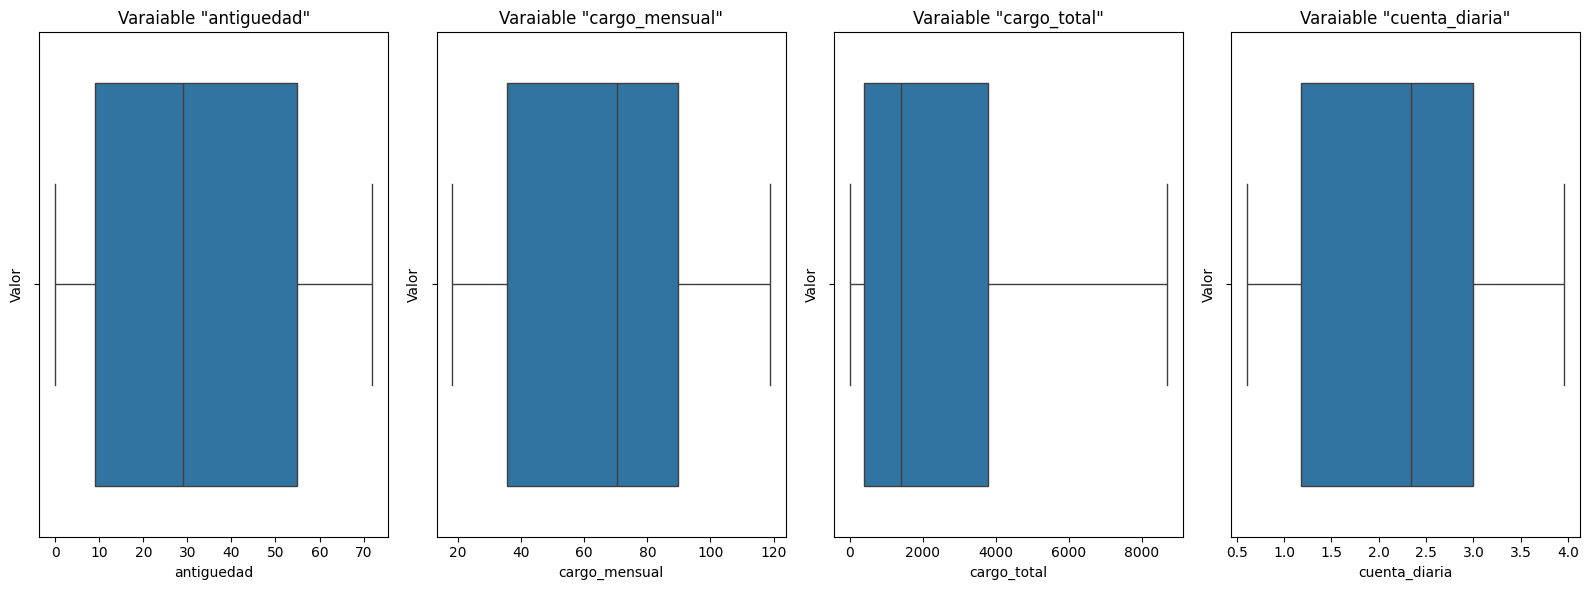

In [653]:
#Código para boxplot.

# Supongamos que df es tu DataFrame y tienes las columnas 'var1', 'var2', 'var3', 'var4'
# que quieres graficar como boxplots

# Lista de las columnas que contienen los valores numéricos
variables = ['antiguedad', 'cargo_mensual', 'cargo_total', 'cuenta_diaria']

# Crear un lienzo con 4 subgráficos (1 columna, 4 filas)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))

# Itera sobre las columnas y genera un boxplot para cada una
for i, var in enumerate(variables):
    sns.boxplot(x=df_telecomX_limpio[var], ax=axes[i])
    axes[i].set_title(f'Varaiable "{var}"')
    axes[i].set_ylabel('Valor')

    # Agregar interactividad para mostrar los datos al pasar el cursor
    mplcursors.cursor(axes[i], hover=True)

# Ajustar el layout para que los gráficos no se sobrepongan
plt.tight_layout()

# Mostrar los gráficos
plt.show()


In [654]:
df_telecomX_limpio.describe()

,antiguedad,cargo_mensual,cargo_total,cuenta_diaria
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304,2.158723
std,24.559481,30.090047,2266.794470,1.003002
min,0.000000,18.250000,0.000000,0.608333
25%,9.000000,35.500000,398.550000,1.183333
50%,29.000000,70.350000,1394.550000,2.345000
75%,55.000000,89.850000,3786.600000,2.995000
max,72.000000,118.750000,8684.800000,3.958333


* **Variable antiguedad.**
  El promedio es de 32.37 meses, la mediana es de 29 meses y la desviación estándar es 24.55 meses.

  Esto sugiere una asimetría positiva leve, donde algunos valores altos podrían estar elevando la media.

  EL coeficiente de variación (CV) es de 75.84%, lo que indica una dispersión muy alta.
  
  Interpretación: La variabilidad en la antigüedad de los clientes es tan marcada que el promedio deja de ser un valor representativo del conjunto.

* **Variable cargo_mensual.**

  El promedio es de \$64.76, la mediana es \$70.35 y la desviación estándar es \$30.09.

  Esto sugiere una asimetría negativa leve, donde algunos valores pequeños podrían estar reduciendo la media.

  El coeficiente de variación (CV) es de 46.46%, lo que indica una dispersión moderadamente alta.
  
  Interpretación: los cargos mensuales varían considerablemente entre clientes.


* **Variable cargo_total.**

  El promedio es de $2,279.73, la mediana es \$1,394.55 y la desviación estándar es \$2,266.79.

  La diferencia notable entre la media y la mediana sugiere una asimetría positiva alta, donde algunos valores extremos elevan el promedio.

  El CV es de 99.43%, lo que indica una alta dispersión.
  
  Interpretación: el total acumulado que pagan los clientes varía ampliamente entre usuarios.

* **Variable cuenta_diaria.**

  El promedio diario es de \$2.16 , la mediana  \$2.35, y la desviación estándar es \$1.00.

  La diferencia sutil entre la media y la mediana sugiere una asimetría negativa muy leve, donde algunos valores bajos pueden estar ligeramente reduciendo la media.

  El CV es de 46.30%, lo que también indica una dispersión moderadamente alta.
  
  Interpretación: los cargos diarios no son uniformes y varían de forma significativa entre clientes.

#####🏷️**Variables Categóricas.**

In [655]:

#Código para distribución de frecuencia.
variables_categóricas = ['evasion', 'genero', 'a_mayor', 'pareja',
       'dependientes','telefonia', 'multilinea', 'internet',
       'seguridad', 'respaldo', 'proteccion', 'soporte', 'tv', 'peliculas',
       'contrato', 'factura_online', 'm_pago','cargo_total']

#Contiene la distribución de frecuencia de cada variable categórica.
frecuencia_variable_categorica = {}

for col in variables_categóricas:
  frecuencia = df_telecomX_limpio[col].value_counts()
  participacion = df_telecomX_limpio[col].value_counts(normalize=True)  # para ver % participación
  frecuencia_variable_categorica[col] = pd.concat([frecuencia,participacion],axis=1)


In [666]:
#Código  para calcular distribución de frecuencia absoluta y relativa para la columna evasión.
print(f"🔢 Distribución de Frecuencia Absoluta y Relativa para Variable 'Evasion'.\n")
df_telecomX_limpio['evasion'].astype(str).str.replace('yes','si',regex=True)

frecuencia_variable_categorica['evasion'].columns = ['Absoluta','Relativa']
v_desersion = frecuencia_variable_categorica['evasion']
display(v_desersion)



🔢 Distribución de Frecuencia Absoluta y Relativa para Variable 'Evasion'.



,Absoluta,Relativa
evasion,,
no,5174,0.73463
si,1869,0.26537


In [664]:

# Reemplazar 'yes' por 'si' en la columna 'evasion' (si es necesario)
df_telecomX_limpio['evasion'] = df_telecomX_limpio['evasion'].astype(str).str.replace('yes', 'si', regex=True)


# Crear gráfico de barras con Plotly usando los datos de v_desersion
fig = go.Figure()

# Agregar barras a la figura usando la frecuencia absoluta almacenada en v_desersion
fig.add_trace(go.Bar(
    x=v_desersion.index,  # Usar el índice como las categorías de 'evasion'
    y=v_desersion['Absoluta'],  # Usar la frecuencia absoluta de v_desersion
    marker_color=['green', 'blue'],  # Colores para las categorías
))

# Ajustar la figura para reducir la separación entre las barras manteniendo el mismo grosor
fig.update_layout(
    title="Frecuencia Absoluta Variable 'Evasion'.",
    xaxis_title='Categorías de Evasión',
    yaxis_title='Frecuencia Absoluta',
    bargap=0.4,  # Espacio entre las barras, ajustado para que estén más juntas
    width=800,   # Ajustar el tamaño de la figura
    height=400,  # Ajustar la altura
    xaxis=dict(tickangle=0),  # Alineación de las etiquetas en el eje X
)

# Mostrar el gráfico
fig.show()


#📄**Informe final.**